In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 数据加载
data = pd.read_csv('heart2.csv')

print("\n数据类型：")
print(data.dtypes)

# 1. 去除缺失值
data = data.dropna()

# 2. 热独编码
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data = pd.get_dummies(data, columns=categorical_cols)

# 3. 打印处理后数据的前几行和数据类型
print("数据的前几行：")
print(data.head())
print("\n数据总量（行数）：", data.shape[0])
print("特征数量（列数）：", data.shape[1])

# 4. 提取特征和标签
X = data.drop(columns=['HeartDisease']).values
y = data['HeartDisease'].values

# 5. 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("\n标准化后的数据（前5行）：")
print(X[:5])









数据类型：
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object
数据的前几行：
   Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_F  Sex_M  ChestPainType_ASY  ...  ChestPainType_NAP  ChestPainType_TA  \
0  False   True              False  ...              False             False   
1   True  False              False  ...         

In [2]:
# 6. 数据集分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. 转换为 PyTorch 的 tensor 格式，并创建 DataLoader
batch_size = 256
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
# 定义神经网络
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()

        # 构建网络层
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))  # 第一个隐藏层的 Dropout

        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))  # 中间层的 Dropout

        self.layers.append(nn.Linear(hidden_layers[-1], 2))  # 输出层
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x


In [4]:
# 定义超参数
input_size = X_train_tensor.shape[1]
hidden_layers = [64, 32]  # 隐藏层神经元数量
dropout_rate = 0.2  # Dropout 的丢弃率
learning_rate = 0.001  # 学习率
alpha = 0.001  # L2 正则化
num_epochs = 150  # 最大迭代次数
early_stop_patience = 20  # 早停的容忍次数

# 模型实例化
model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=alpha)

# 早停实现
best_val_loss = float('inf')
patience_counter = 0

# 记录训练和验证的损失与准确率
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

HeartDiseaseANN(
  (layers): ModuleList(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
  (softmax): Softmax(dim=1)
)


In [5]:
# 训练循环
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    # 逐批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # 累加损失和正确预测数
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()

    # 计算平均训练损失和准确率
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_correct / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # 验证阶段
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()

    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_correct / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}")

    # 早停逻辑
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"Early stop triggered! Stopping training at epoch {epoch+1}.")
            break


Epoch 1/150, Training Loss: 0.6845, Training Accuracy: 0.5477, Validation Loss: 0.6744, Validation Accuracy: 0.5870
Epoch 2/150, Training Loss: 0.6757, Training Accuracy: 0.5613, Validation Loss: 0.6648, Validation Accuracy: 0.5924
Epoch 3/150, Training Loss: 0.6643, Training Accuracy: 0.6308, Validation Loss: 0.6544, Validation Accuracy: 0.6902
Epoch 4/150, Training Loss: 0.6519, Training Accuracy: 0.7139, Validation Loss: 0.6430, Validation Accuracy: 0.7609
Epoch 5/150, Training Loss: 0.6409, Training Accuracy: 0.7643, Validation Loss: 0.6304, Validation Accuracy: 0.7989
Epoch 6/150, Training Loss: 0.6242, Training Accuracy: 0.8052, Validation Loss: 0.6162, Validation Accuracy: 0.8370
Epoch 7/150, Training Loss: 0.6122, Training Accuracy: 0.8215, Validation Loss: 0.6007, Validation Accuracy: 0.8424
Epoch 8/150, Training Loss: 0.5896, Training Accuracy: 0.8351, Validation Loss: 0.5841, Validation Accuracy: 0.8424
Epoch 9/150, Training Loss: 0.5750, Training Accuracy: 0.8283, Validatio

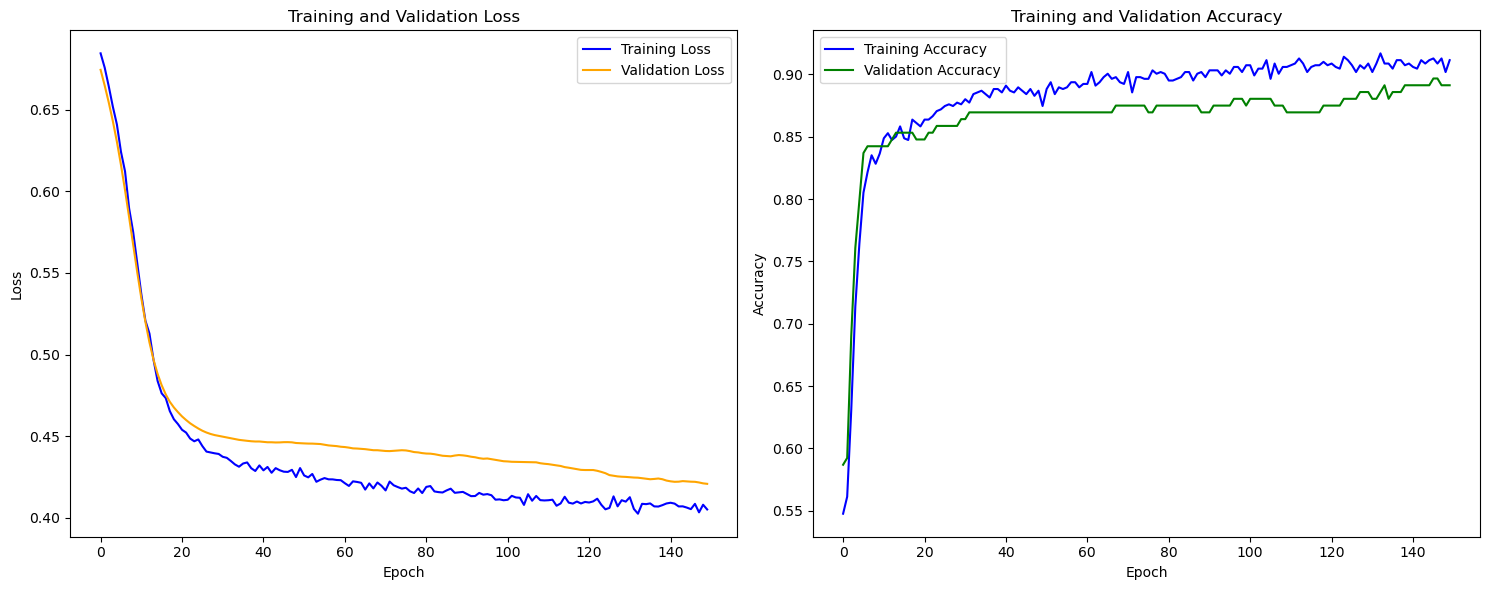

In [6]:
# 可视化训练和验证过程
plt.figure(figsize=(15, 6))

# 绘制训练和验证损失
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 绘制训练和验证准确率
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
